<a href="https://colab.research.google.com/github/Joefamouze/image_captioning/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Visual Attention

Image captioning models take an image as input, and output text. Ideally, I want the output of the model to accurately describe the events/things in the image, similar to a caption a human might provide.

In order to generate text, I will build an encoder-decoder model, where the encoder output embedding of an input image, and the decoder output text from the image embedding

I this notebook, I will use the model architecture similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, and build Attention-based image captioning model.

This notebook is an end-to-end example. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.



In [1]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.15.0


# Preparing pretrained model for transfer learning

The InceptionResNetV2 will be used for this purpose. We extract the features from the model. This CNN backbone extracts a "thought vector" from input images



In [2]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


# Filter and Preprocess
Here we preprocess the dataset. The function below:

resize image to (IMG_HEIGHT, IMG_WIDTH) shape
rescale pixel values from [0, 255] to [0, 1]
return image(image_tensor) and captions(captions) dictionary.
Note: This dataset is too large to store in an local environment. Therefore, It is stored in a public GCS bucket located in us-central1. So if you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.

In [3]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

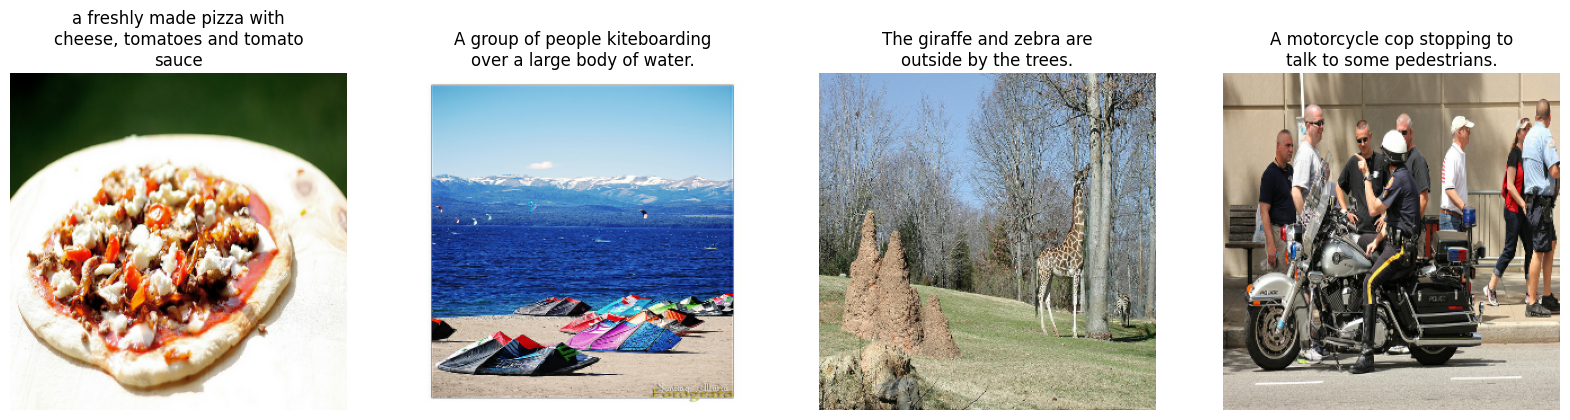

In [4]:
#visualize

f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

# Text Preprocessing
We add special tokens to represent the starts (<start>) and the ends (<end>) of sentences.
Start and end tokens are added here because we are using an encoder-decoder model and during prediction, to get the captioning started we use <start> and since captions are of variable length, we terminate the prediction when we see the <end> token.

Then create a full list of the captions for further preprocessing.

In [5]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

# Preprocess and tokenize the captions
Here we transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top VOCAB_SIZE words.
Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the length MAX_CAPTION_LEN. Here we directly specify 64 number which is sufficient for this dataset.


In [6]:
MAX_CAPTION_LEN = 64


# override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))


In [7]:
#sampling the tokenizer

tokenizer(["<start> What does platitude mean? <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[   3, 1025,  920,    1, 2661,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [8]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())


In [9]:
sample_captions

[b'<start> A picture of a refrigerator with little food inside <end>',
 b'<start> One bear observes visitors at the zoo, while another bear sleeps. <end>',
 b'<start> A man laughs while eating a piece of pizza. <end>',
 b'<start> a couple of computer monitors on a white desk <end>',
 b'<start> A street filled with traffic next to tall buildings. <end>']

In [10]:
for word_id in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[word_id], end=" ")

<start> a picture of a refrigerator with little food inside <end>                                                      

In [11]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

# Create a tf.data dataset for training
Applying the adapted tokenization to all the examples and create tf.data Dataset for training.

Here we are also creating labels by shifting texts from feature captions.
If we have an input caption "<start> I love cats <end>", its label should be "I love cats <end> <padding>".
With that, the model can try to learn to predict I from <start>.

The dataset should return tuples, where the first elements are features (image_tensor and caption) and the second elements are labels (target).

In [12]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [13]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2 2452   14  229    2 4074 1934  537    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[   2 2452   14  229    2 4074 1934  537    4    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2  707  190    5    2   12 1654    2 1508    4    0    0    0
    0    0    0    0    0    0    0 

# Model
Now let's design an image captioning model.
It consists of an image encoder, followed by a caption decoder.

Image Encoder
The image encoder model is very simple. It extracts features through a pre-trained model and passes them to a fully connected layer.

In this example, we extract the features from convolutional layers of InceptionResNetV2 which gives us a vector of (Batch Size, 8, 8, 1536).
We reshape the vector to (Batch Size, 64, 1536)
We squash it to a length of ATTENTION_DIM with a Dense Layer and return (Batch Size, 64, ATTENTION_DIM)
Later, the Attention layer attends over the image to predict the next word.

In [14]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [15]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [16]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

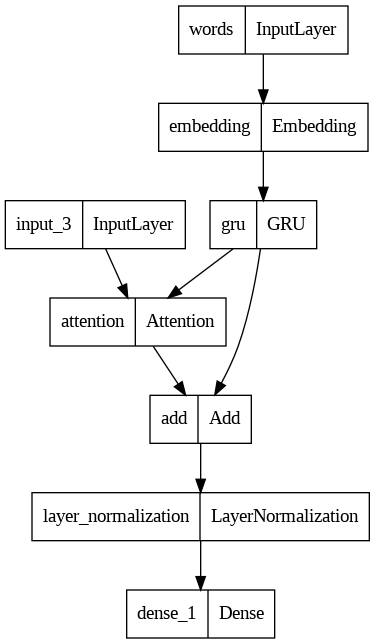

In [17]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [18]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                            

# Training Model
Now we defined the encoder and the decoder. We combine them into an image model for training.
It has two inputs (image_input and word_input, and an output (decoder_output). This definition should correspond to the definition of the dataset pipeline.

In [19]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

# Loss Function
The loss function is a simple cross-entropy, but we need to remove padding (0) when calculating it.
So here we extract the length of the sentence (non-0 part), and compute the average of the loss only over the valid sentence part.

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [21]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

# Training loop
Now we can train the model using the standard model.fit API.
It takes around 15-20 minutes with NVIDIA T4 GPU to train 1 epoch.

We will train the model for 2 epochs

In [22]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=2)

Epoch 1/2
2586/2586 [==============================] - 1020s 384ms/step - loss: 0.5841
Epoch 2/2
2586/2586 [==============================] - 997s 383ms/step - loss: 0.4246
CPU times: user 26min 41s, sys: 2min 28s, total: 29min 10s
Wall time: 34min 56s


# Caption!
The predict step is different from the training, since we need to keep track of the GRU state during the caption generation, and pass a predicted word to the decoder as an input at the next time step.

In order to do so, let's define another model for prediction while using the trained weights, so that it can keep and update the GRU state during the caption generation.

In [23]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

1. Initialize the GRU states as zero vectors.
2. Preprocess an input image, pass it to the encoder, and extract image features.
3. Setup word tokens of <start> to start captioning.
4. In the for loop, we

- pass word tokens (dec_input), GRU states (gru_state) and image features (features) to the prediction decoder and get predictions (predictions), and the updated GRU states.
- select Top-K words from logits, and choose a word probabilistically so that we avoid computing softmax over VOCAB_SIZE-sized vector.
- stop predicting when the model predicts the <end> token.
- replace the input word token with the predicted word token for the next step.

In [24]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

a man wearing a hat holding a baseball bat.
a man wearing a striped shirt standing with a snowboard.
this man has a purple hat with his hand.
a person is looking at the camera as he takes a swing at his arms.
a person wearing headphones and an umbrella.


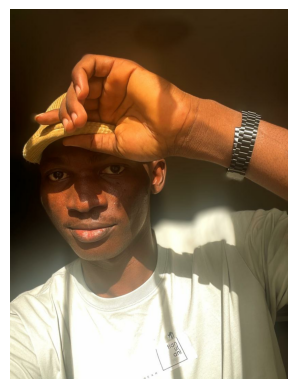

In [29]:
filename = '/content/joe.jpeg'

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

people on skis watching a baseball game.
a couple of boys ride a skateboarding down a street.
a group of men riding on top of a wave in a field.


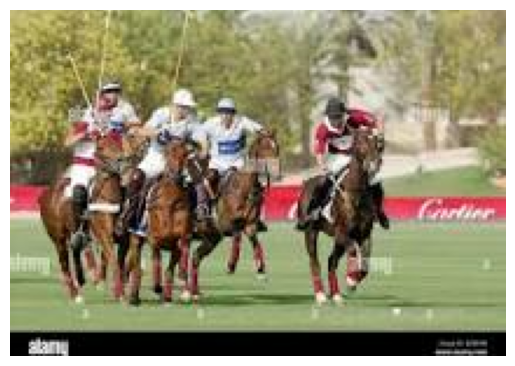

In [28]:
filename = '/content/polos.jpeg'

for i in range(3):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

#Summary

In this notebook I trained and ecoder decoder model that generates caption for an image.
The model did not perform well. A longer training period could help the model's performance.